* 整理自链接： https://hrl.boyuai.com/chapter/2/ddpg%E7%AE%97%E6%B3%95

&&  https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/

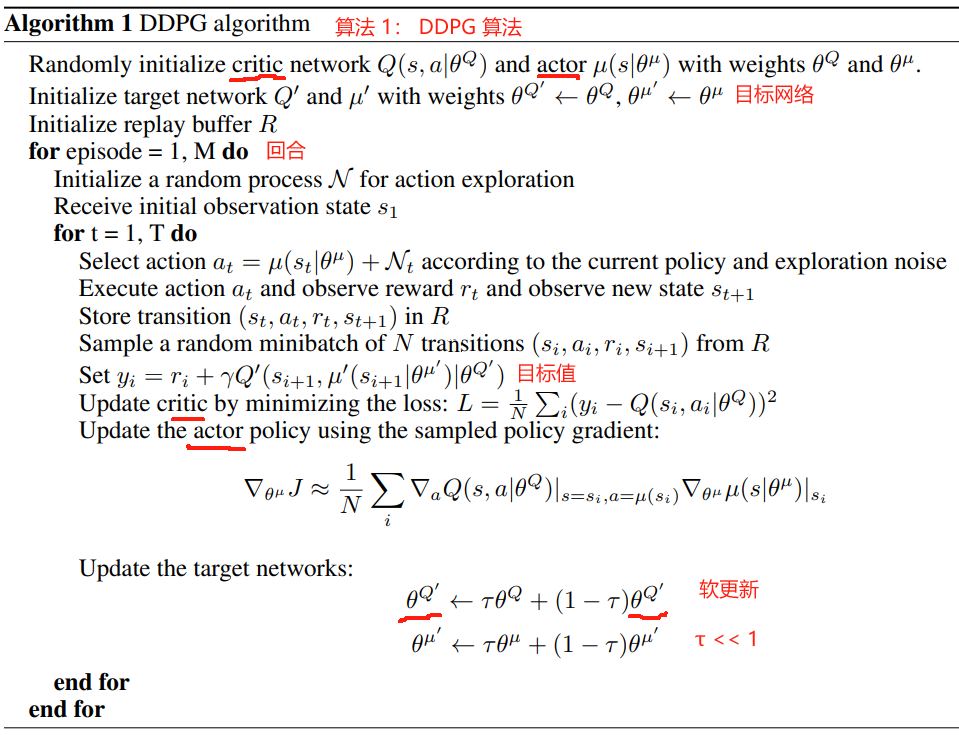

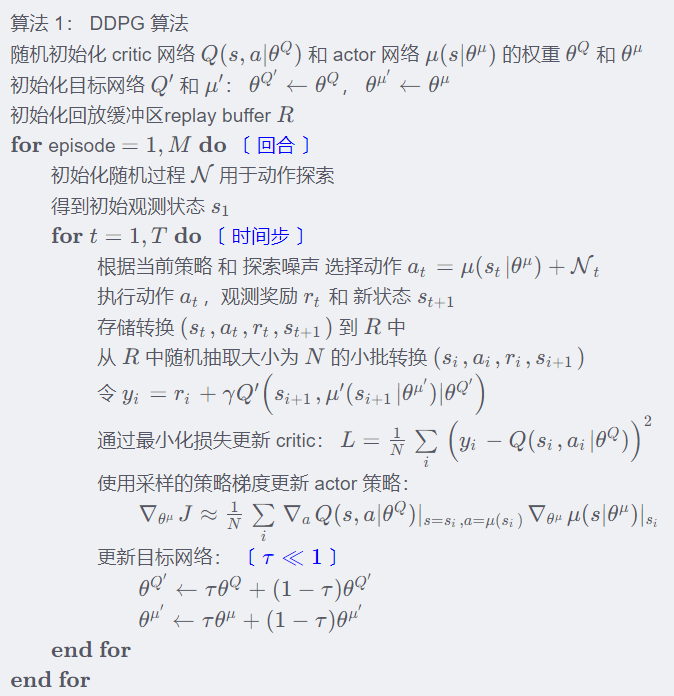

# Code

In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.0 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 这样 无需 plt.show()  直接在代码单元下方显示图
from tqdm import tqdm
import random
import collections
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

##   类模块

### PolicyNet 策略网络 (actor)

一层隐藏层。

输出用 正切层 $y=\text{tanh}(x)$ 作为激活函数。值域为 $[-1,1]$

In [3]:
class PolicyNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound): # # action_bound 是环境可以接受的动作最大值
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    self.action_bound = action_bound

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return torch.tanh(self.fc2(x)) * self.action_bound

### 价值网络 (critic)

输入： 状态 和 动作 拼接后的向量

输出： 状态-动作 对的价值  Q

In [4]:
class QValueNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim) # 全连接层
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc_out = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x, a):
    cat = torch.cat([x, a], dim=1) # 拼接 状态 和 动作
    x = F.relu(self.fc1(cat)) # 隐藏层 使用 ReLU 激活函数
    x = F.relu(self.fc2(x))
    return self.fc_out(x)

### Actor-Critic 算法

In [16]:
class DDPG:
  """ Deep DPG (DDPG) 算法"""
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, tau, sigma, device):
    # 策略 网络
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
    # 价值 网络
    self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
    # 相应的目标网络
    self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
    self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
    # 初始化 目标网络  和 在线网络相同的参数
    self.target_actor.load_state_dict(self.actor.state_dict())
    self.target_critic.load_state_dict(self.critic.state_dict())

    # 使用 Adam 优化器
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma # 折扣因子
    self.sigma = sigma  # 高斯噪声的标准差， 均值为 0
    self.tau = tau  # 目标网络 软更新的参数
    self.action_dim = action_dim
    self.device = device

  def take_action(self, state): # 遵循 当前策略 + 高斯噪声 选取动作
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    action = self.actor(state).item()
    # 给动作添加噪声，增加探索
    action = action + self.sigma * np.random.randn(self.action_dim)
    return action

  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)  # τ 远小于 1

  def update(self, transition_dict): # 每回合 更新一次
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device) # view(-1, 1) 数据维度修改为 1 列， 行数自适应
    # ↑ 现在 动作是一个数值，而不是离散的整数，强制 数据类型 为 torch.float
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

    # 计算 y_i
    next_q_values = self.target_critic(next_states, self.target_actor(next_states))
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)

    # 计算损失
    actor_loss = -torch.mean(self.critic(states, self.actor(states)))
    critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))  # 均方误差损失函数

    # 更新 策略网络
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    # 更新价值网络
    self.critic_optimizer.zero_grad()  # 梯度重置为 0
    critic_loss.backward() # 反向传播
    self.critic_optimizer.step() # 更新

    # 更新 目标网络
    self.soft_update(self.actor, self.target_actor)
    self.soft_update(self.critic, self.target_critic)


### —— 经验回放

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

## 训练


环境链接： https://gymnasium.farama.org/environments/classic_control/pendulum/

In [21]:
# Create and wrap the environment
env_name = "Pendulum-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值

total_num_episodes = 500  # 回合总数 M
hidden_dim = 128
actor_lr = 3e-4    # 学习率
critic_lr = 3e-3
gamma = 0.98       # 折扣因子 γ
tau = 0.005  # 软更新参数 远小于 1
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声 标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# Observation-space of
state_dim = env.observation_space.shape[0]
# Action-space of
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0] # 最大动作值

rewards_over_seeds = []

for seed in [0, 42, 20, 24, 10]:  #  seeds
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Reinitialize agent every seed
    agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, gamma, tau, sigma, device)

    replay_buffer = ReplayBuffer(buffer_size) # 创建回放经验池

    reward_over_episodes = []

    # off-policy异策略
    for episode in range(total_num_episodes):
        transition_dict = {'states':[], 'actions':[], 'next_states':[], 'rewards':[], 'dones':[]}
        state, info = wrapped_env.reset(seed=seed)
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated

            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state

            if replay_buffer.size() > minimal_size:
              b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
              transition_dict = {'states': b_s, 'actions': b_a, 'rewards': b_r, 'next_states': b_ns, 'dones': b_d }
              agent.update(transition_dict)

        reward_over_episodes.append(wrapped_env.return_queue[-1])

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

# Pendulum-v1
# 奖励的值在 -16 ~ 0
# 回合长度阈值为 200

# 运行时长： CPU 大约 1h

Episode: 0 Average Reward: -1264
Episode: 0 Average Reward: -219
Episode: 0 Average Reward: -182
Episode: 0 Average Reward: -365
Episode: 0 Average Reward: -227


## 可视化

https://seaborn.pydata.org/generated/seaborn.lineplot.html

[Text(0.5, 1.0, 'DDPG for Pendulum-v1')]

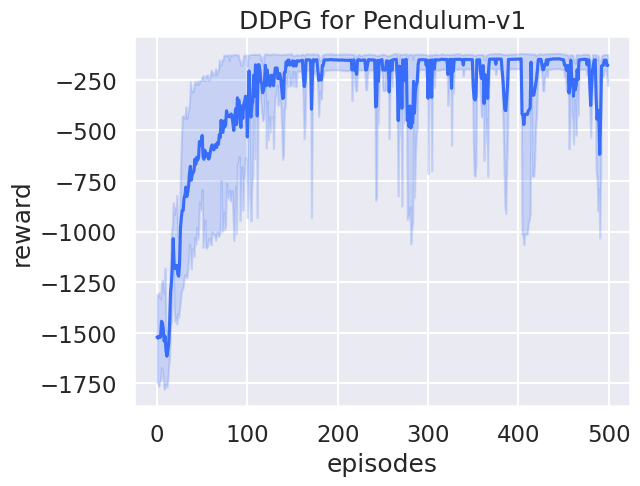

In [22]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="DDPG for {}".format(env_name)
)

[Text(0.5, 1.0, 'DDPG for Pendulum-v1')]

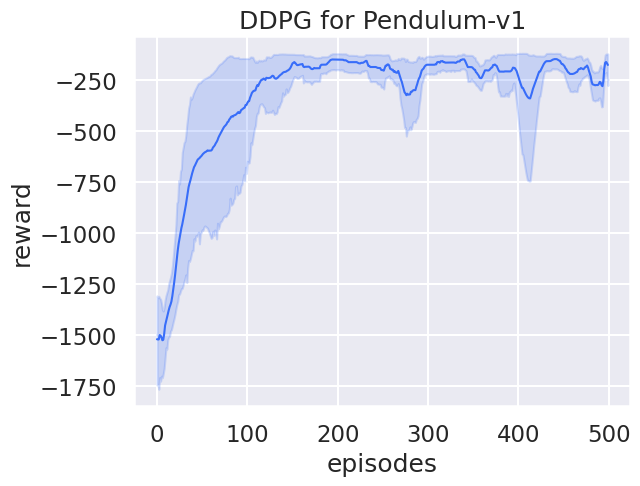

In [23]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[ reward  for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 19) # 调这里 更改平滑度

df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="DDPG for {}".format(env_name)
)   # 调线宽

# Pendulum-v1
# 奖励的值在 -16 ~ 0
# 回合长度阈值为 200

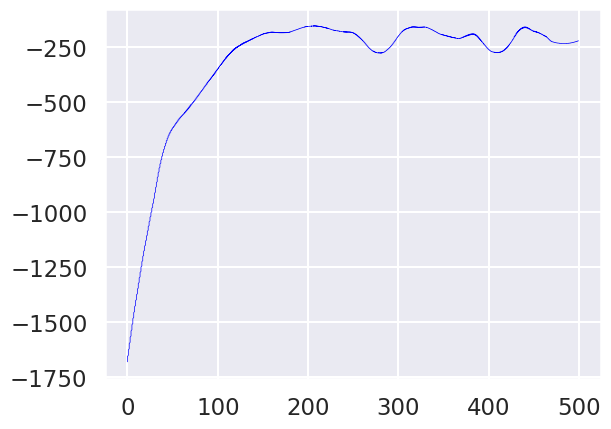

In [25]:
from scipy.signal import savgol_filter
%matplotlib inline

# 应用平滑滤波器
window_size = 300  # 窗口大小，即平滑的程度
polyorder = 2     # 多项式的阶数

# 对 y 值使用 savgol_filter
smoothed_y = savgol_filter(df1['reward'], window_length=window_size, polyorder=polyorder)

# 绘制平滑后的线图
plt.plot(df1['episodes'], smoothed_y, color='blue', linewidth=0.5)   # 2

# 将训练结果 存到 本地， 方便后续进行比较 (DataFrame && csv)


https://pandas.pydata.org/docs/user_guide/10min.html#importing-and-exporting-data

In [ ]:
print(YES)   # 无需求则无需运行后续代码

In [26]:
import os
# 查看当前目录
print(os.getcwd())

/content


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
%cd /content/drive/MyDrive/Actor-Critics_Test
!ls

# 在 目录 /content/drive/MyDrive 下新建一个文件夹 Actor-Critics_Test

/content/drive/MyDrive/Actor-Critics_Test
A2C_1.csv  A2C.csv  Actor-Critics.csv  Actor-Critics_QAC.csv  weights


In [29]:
DDPG_df = pd.DataFrame(
    {
        "DDPG": smoothed_y
    }
)

if not os.path.exists("Actor-Critics_Test"):
  os.mkdir("Actor-Critics_Test")


DDPG_df.to_csv("/content/drive/MyDrive/Actor-Critics_Test/DDPG.csv")

In [30]:
my_df_loaded = pd.read_csv('/content/drive/MyDrive/Actor-Critics_Test/DDPG.csv', index_col=0)   # index_col=0 指定行索引的位置
my_df_loaded

,DDPG
0,-1682.649227
1,-1676.629619
2,-1670.624331
3,-1664.633362
4,-1658.656713
...,...
2495,-222.679563
2496,-222.372522
2497,-222.061502
2498,-221.746500
